In [1]:


# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.0


In [6]:
# from __future__ import absolute_import, division, print_function

# system libs
# import time
# t0 = time.clock()
import os
# import pathlib

# data science libs
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns

# deep learning/AI libs
# import keras
# from keras import backend as K

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Linear, ReLU

from torch_geometric.nn import GCNConv, GATv2Conv, GATConv, SAGEConv
from torch_geometric.data import Data
# from torch_geometric.nn import global_mean_pool


1.12.0


## Data & preprocess

In [7]:
Edges_train = pd.read_excel('graph10.xlsx', sheet_name= 'Sheet2')
Edges_test = pd.read_excel('graph10.xlsx', sheet_name= 'Sheet4')
Edges_validation = pd.read_excel('graph10.xlsx', sheet_name= 'Sheet6')

dataset_train = pd.read_excel('graph10.xlsx', sheet_name= 'Train2')
dataset_test = pd.read_excel('graph10.xlsx', sheet_name = 'Test2')
dataset_validation = pd.read_excel('graph10.xlsx', sheet_name= 'Validation')

#one_hot_cols = pd.get_dummies(dataset_train['Flat Type'], prefix='Flat')
#dataset_train = dataset_train.drop(columns=['Flat Type'])
#dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

#one_hot_cols = pd.get_dummies(dataset_test['Flat Type'], prefix='Flat')
#dataset_test = dataset_test.drop(columns=['Flat Type'])
#dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

#one_hot_cols = pd.get_dummies(dataset_train['Room Type'], prefix='Room')
#dataset_train = dataset_train.drop(columns=['Room Type'])
#dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

#one_hot_cols = pd.get_dummies(dataset_test['Room Type'], prefix='Room')
#dataset_test = dataset_test.drop(columns=['Room Type'])
#dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

# one_hot_cols = pd.get_dummies(dataset_train['Wing Orientation'], prefix='Wing')
# dataset_train = dataset_train.drop(columns=['Wing Orientation'])
# dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

# one_hot_cols = pd.get_dummies(dataset_test['Wing Orientation'], prefix='Wing')
# dataset_test = dataset_test.drop(columns=['Wing Orientation'])
# dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

# one_hot_cols = pd.get_dummies(dataset_train['Flat Orientation'], prefix='Flat Orientation')
# dataset_train = dataset_train.drop(columns=['Flat Orientation'])
# dataset_train = pd.concat([one_hot_cols, dataset_train], axis=1)

# one_hot_cols = pd.get_dummies(dataset_test['Flat Orientation'], prefix='Flat Orientation')
# dataset_test = dataset_test.drop(columns=['Flat Orientation'])
# dataset_test = pd.concat([one_hot_cols, dataset_test], axis=1)

dataset_train.fillna(0, inplace=True)
dataset_test.fillna(0, inplace=True)
dataset_validation.fillna(0, inplace=True)

train_X = dataset_train.iloc[0:, :15]
train_Y = dataset_train.iloc[0:, 15:]

test_X = dataset_test.iloc[0:, :15]
test_Y = dataset_test.iloc[0:, 15:]

validation_X = dataset_validation.iloc[0:, :15]
validation_Y = dataset_validation.iloc[0:, 15:]

scalerX = StandardScaler().fit(train_X)
scalerY = StandardScaler().fit(train_Y)
train_X = scalerX.transform(train_X)
train_Y = scalerY.transform(train_Y)
test_X = scalerX.transform(test_X)
test_Y = scalerY.transform(test_Y)

validation_X = scalerX.transform(validation_X)
validation_Y = scalerY.transform(validation_Y)

edges_train = Edges_train.values - 1
edges_train = torch.from_numpy(edges_train).t()
edges_train = edges_train.long()

edges_test = Edges_test.values - 1
edges_test = torch.from_numpy(edges_test).t()
edges_test = edges_test.long()

edges_validation = Edges_validation.values - 1
edges_validation = torch.from_numpy(edges_validation).t()
edges_validation = edges_validation.long()

train = pd.concat([pd.DataFrame(train_X), pd.DataFrame(train_Y)], axis=1)
test = pd.concat([pd.DataFrame(test_X), pd.DataFrame(test_Y)], axis=1)
validation = pd.concat([pd.DataFrame(validation_X), pd.DataFrame(validation_Y)], axis=1)

train_X = torch.tensor(np.array(train_X.astype('f')))
train_Y = torch.tensor(np.array(train_Y.astype('f')))

test_X = torch.tensor(np.array(test_X.astype('f')))
test_Y = torch.tensor(np.array(test_Y.astype('f')))

validation_X = torch.tensor(np.array(validation_X.astype('f')))
validation_Y = torch.tensor(np.array(validation_Y.astype('f')))


train_data = Data(x = train_X, edge_index = edges_train, y = train_Y)
test_data = Data(x = test_X, edge_index = edges_test, y = test_Y)
validation_data = Data(x = validation_X, edge_index = edges_validation, y = validation_Y)

# ACH_MEAN = dataset_train.ACH.mean()
# ACH_var = dataset_train.ACH.var()
# ACH_Min = dataset_train.ACH.min()
# ACH_Max = dataset_train.ACH.max()
# CP_MEAN = dataset_train.CP.mean()
# CP_var = dataset_train.CP.var()
# CP_Min = dataset_train.CP.min()
# CP_Max = dataset_train.CP.max()


train_Y_mean = train_Y.mean()
train_Y_var = train_Y.var()


## Model Defi.

### Model class

In [10]:


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(21, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 112)
        # self.conv2 = GCNConv(hidden_channels, 50)
        # self.lin1 = Linear(50,256)
        self.lin2 = Linear(112,256)
        self.lin3 = Linear(256,100)
        self.lin4 = Linear(100,1)

        self.bnm1 = nn.BatchNorm1d(112, momentum=0.1)
        self.bnm2 = nn.BatchNorm1d(256, momentum=0.1)
        self.bnm3 = nn.BatchNorm1d(100, momentum=0.1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.1, training=self.training)
        # x = self.dropout(x)
        x = self.conv2(x, edge_index)
        # x = self.lin1(x)
        x = self.bnm1(x)
        x = x.relu()
        x = self.dropout(x)
        x = self.lin2(x)
        x = self.bnm2(x)
        x = x.relu()
        x = self.lin3(x)
        x = self.bnm3(x)
        x = x.relu()
        x = self.lin4(x)  
        return x

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(15, 150)
        self.conv2 = GCNConv(150, 200)
        self.lin2 = Linear(200,400)
        self.lin3 = Linear(400,200)
        self.lin4 = Linear(200,1)

        self.pool1 = nn.MaxPool2d(2,2)

        self.bnm1 = nn.BatchNorm1d(200, momentum=0.1)
        self.bnm2 = nn.BatchNorm1d(400, momentum=0.1)
        self.bnm3 = nn.BatchNorm1d(200, momentum=0.1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edge_index)
        # x = self.lin1(x)
        x = self.bnm1(x)
        x = x.relu()
        x = self.dropout(x)
        x = self.lin2(x)
        x = self.bnm2(x)
        x = x.relu()
        # x = self.dropout(x)
        x = self.lin3(x)
        x = self.bnm3(x)
        x = x.relu()
        x = self.lin4(x)  
        return x



In [11]:
# hyper params
batch_size = 100
nb_classes = 1
nb_epoch = 1000

# 生成模型
model = GCN1()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.025, weight_decay=1e-4)
# 学习算法
optimizer = torch.optim.Adam(model.parameters(), lr=0.008, weight_decay=1e-4)

# criterion = torch.nn.MSELoss()
criterion = torch.nn.HuberLoss(reduction='mean',delta=0.15)

'''
train1个epoch(all data喂进去一次)
'''
# 这种写法非常不好，没有入参，等于model或任何其他参数都是在调用 全局变量
def train():
      # to gpu
      # model.to("cuda:0")
      # train_data.to("cuda:0")
      
      # training
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      
      # 获取output 待计算loss和优化模型
      out = model(train_data.x, train_data.edge_index)
      #out = model(train_data.x)
      loss = criterion(out, train_data.y)  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      
      # 优化参数
      optimizer.step()  # Update parameters based on gradients.
      return loss

# lmbd = 0.01
# def train():
#       model.to("cuda:0")
#       train_data.to("cuda:0")
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(train_data.x, train_data.edge_index)
#       #out = model(train_data.x)
#       loss = criterion(out, train_data.y)  # Compute the loss solely based on the training nodes.
#       reg_loss = None
#       for param in model.parameters():
#           if reg_loss is None:
#               reg_loss = 0.5 * torch.sum(param**2)
#           else:
#               reg_loss = reg_loss + 0.5 * param.norm(2)**2

#       loss += lmbd * reg_loss
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss

def test():
      model.eval()
      # test_data.to("cuda:0")
      #out = model(test_data.x)
      out = model(test_data.x, test_data.edge_index)
      loss = criterion(out, test_data.y)
      pred = out  # Use the class with highest probability.
      # train_correct = abs((pred-test_data.y/test_data.y))< 0.5  # Check against ground-truth labels.
      # train_acc = int(train_correct.sum()) / int(len(test_data)) 
      # loss.backward() 
      # optimizer.step()
      return loss

Train_losses = []
Test_losses = []

for epoch in range(1, 1001):
    Train_loss = train()
    Test_loss = test()
    
    model.eval()
    test_data.to("cuda:0")
    train_data.to("cuda:0")
    #test_predictions = model(test_data.x)
    test_predictions = model(test_data.x, test_data.edge_index)
    train_predictions = model(train_data.x, train_data.edge_index)
    # test_predictions_inverse = scalerY.inverse_transform(test_predictions.detach().numpy())
    test_correct = abs((test_predictions-test_data.y)/test_predictions) < 0.25  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / len(test_predictions)
    train_correct = abs((train_predictions-train_data.y)/train_predictions) < 0.25  # Check against ground-truth labels.
    train_acc = int(train_correct.sum()) / len(train_predictions)
    Train_losses.append(Train_loss.detach().cpu().numpy())
    Test_losses.append(Test_loss.detach().cpu().numpy())
    
    print(f'Epoch: {epoch:03d}, Train_Loss: {Train_loss:.4f}, Test_Loss: {Test_loss:.4f}, Train_Acc:{train_acc:.4f}, Test_Acc: {test_acc:.4f}')
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')


def draw_loss():
  plt.figure()
  plt.title('loss',fontsize=24)
  plt.plot(Train_losses,'-')
  plt.plot(Test_losses,'-')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train','Test'])
  plt.show

draw_loss()


AssertionError: Torch not compiled with CUDA enabled

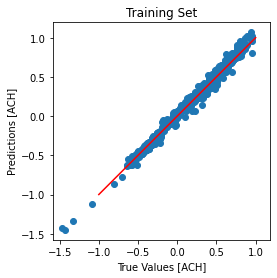

In [ ]:
model.eval()
train_predictions = model(train_data.x, train_data.edge_index)
# train_predictions = model(train_data.x)
train_predictions_inverse = scalerY.inverse_transform(train_predictions.detach().cpu().numpy())
train_Y_inverse = scalerY.inverse_transform(train_Y)
prediction_frame = pd.DataFrame(train_predictions_inverse, index=dataset_train.index)
test_2 = pd.concat([pd.DataFrame(test_X), pd.DataFrame(train_Y)], axis=1)
result = pd.concat([test_2, prediction_frame], axis=1)
result.rename(columns={0:'Prediction'},inplace = True)
# result = test.join(prediction_frame)
# pd.merge(test, prediction_frame, left_index=True)
result.to_csv('result_Analysis_MAE_train.csv')

writer = pd.ExcelWriter('result_analysis_train.xlsx')
result.to_excel(writer, 'Sheet1')
writer.save()

fig = plt.figure()
plt.title('Training Set')
plt.scatter(train_Y_inverse, train_predictions_inverse)
plt.xlabel('True Values [ACH]')
plt.ylabel('Predictions [ACH]')
x = np.linspace(-1,1)
y = x
plt.plot(x, y, '-r', label='y=x')
plt.axis('equal')
plt.axis('square')
# plt.show()
fig.set_size_inches(6, 4)
fig.savefig('Training set.png', dpi=fig.dpi)
# plt.xlim([-0.1, 55])
# plt.ylim([-0.1, 55])
# _ = plt.plot([-100, 100], [-100, 100])

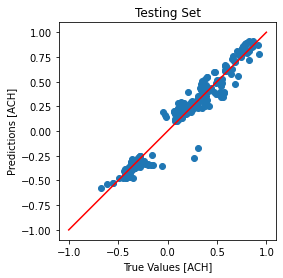

In [ ]:
model.eval()
test_predictions = model(test_data.x, test_data.edge_index)
# test_predictions = model(test_data.x)
test_predictions_inverse = scalerY.inverse_transform(test_predictions.detach().cpu().numpy())
test_Y_inverse = scalerY.inverse_transform(test_Y)
prediction_frame = pd.DataFrame(test_predictions_inverse, index=dataset_test.index)
# test_2 = pd.concat([pd.DataFrame(test_X.detach().numpy()), pd.DataFrame(test_Y.detach().numpy())], axis=1)
result = pd.concat([dataset_test, prediction_frame], axis=1)
result.rename(columns={0:'Prediction'},inplace = True)
# result = test.join(prediction_frame)
# pd.merge(test, prediction_frame, left_index=True)
result.to_csv('result_Analysis_MAE.csv')

writer = pd.ExcelWriter('result_analysis.xlsx')
result.to_excel(writer, 'Sheet1')
writer.save()

fig = plt.figure()
plt.title('Testing Set')
plt.scatter(test_Y_inverse, test_predictions_inverse)
plt.xlabel('True Values [ACH]')
plt.ylabel('Predictions [ACH]')
x = np.linspace(-1,1)
y = x
plt.plot(x, y, '-r', label='y=x')
plt.axis('equal')
plt.axis('square')
# plt.show()
fig.set_size_inches(6, 4)
fig.savefig('MAE.png', dpi=fig.dpi)
# plt.xlim([-0.1, 55])
# plt.ylim([-0.1, 55])
# _ = plt.plot([-100, 100], [-100, 100])

In [ ]:
def train_and_pred(validation_data, validation_labels):
  model.cpu()
  preds = model(validation_data.x, validation_data.edge_index)
  preds = scalerY.inverse_transform(preds.detach().numpy())
  validation_labels['Cp'] = pd.Series(preds[:,0].reshape(1, -1)[0])
  submission = pd.concat([validation_labels['Id'], validation_labels['Cp']], axis=1)
  submission.to_csv('./Validation Results.csv', index=False)

In [ ]:
validation_labels = pd.DataFrame(scalerY.inverse_transform(validation_Y.detach().numpy()))
validation_labels.columns = ['Id']
train_and_pred(validation_data, validation_labels)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def drawComparison (ACH, PRED):
    fig = plt.figure()
    plt.title('Testing Set', FontSize=24)
    plt.scatter(ACH, PRED)
    plt.xlabel('True Values [ACH]', FontSize=24)
    plt.ylabel('Predictions [ACH]', FontSize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    x = np.linspace(-5,60,20)
    y = x
    plt.plot(x, y, '-r', label='y=x')
    plt.axis('equal')
    plt.axis('square')

    fig.set_size_inches(16, 9)
    fig.savefig('comparison', dpi=fig.dpi)

MAE = pd.read_csv('result_Analysis_MAE.csv')
# ACH_MAE = MAE['ACH']
ACH_MAE = MAE['W1 Cp']
PRED_MAE = MAE['Prediction']
absolute_diff_MAE = abs(ACH_MAE-PRED_MAE)
absolute_percentage_diff_MAE = abs(ACH_MAE-PRED_MAE)/abs(ACH_MAE)
drawComparison(ACH_MAE, PRED_MAE)

# Rating_GT = MAE['ACH']
# Rating_Pred = MAE['ACH']
# is_equal = MAE['ACH']
Rating_GT = MAE['W1 Cp']
Rating_Pred = MAE['W1 Cp']
is_equal = MAE['W1 Cp']

Output = pd.concat([ACH_MAE, PRED_MAE, absolute_diff_MAE, 
                    absolute_percentage_diff_MAE, Rating_GT, Rating_Pred, is_equal],axis=1,ignore_index=True)
# Output.columns=['ACH','PRED_MAE','absolute_diff_MAE',
                              # 'absolute_percentage_diff_MAE','Rating_GT', 'Rating_Pred']

Output.columns=['ACH','PRED_MAE','absolute_diff_MAE',
                              'absolute_percentage_diff_MAE','Rating_GT', 'Rating_Pred','is_equal']

# Output.loc[Output['ACH'] <=5, 'Rating_GT'] = 0
# Output.loc[(Output['ACH'] >5) & (Output['ACH'] <=10), 'Rating_GT'] = 1
# Output.loc[(Output['ACH'] >10) & (Output['ACH'] <=30), 'Rating_GT'] = 2
# Output.loc[(Output['ACH'] >30) & (Output['ACH'] <=70), 'Rating_GT'] = 3
# # Output.loc[(Output['ACH'] >44) & (Output['ACH'] <=70), 'Rating_GT'] = 4
# Output.loc[Output['ACH'] >70, 'Rating_GT'] = 4

# Output.loc[Output['PRED_MAE'] <=5, 'Rating_Pred'] = 0
# Output.loc[(Output['PRED_MAE'] >5) & (Output['PRED_MAE'] <=10), 'Rating_Pred'] = 1
# Output.loc[(Output['PRED_MAE'] >10) & (Output['PRED_MAE'] <=30), 'Rating_Pred'] = 2
# Output.loc[(Output['PRED_MAE'] >30) & (Output['PRED_MAE'] <=70), 'Rating_Pred'] = 3
# # Output.loc[(Output['PRED_MAE'] >44) & (Output['PRED_MAE'] <=70), 'Rating_Pred'] = 4
# Output.loc[Output['PRED_MAE'] >70, 'Rating_Pred'] = 4

# Output.loc[Output['ACH'] <=4, 'Rating_GT'] = 0
# Output.loc[(Output['ACH'] >4) & (Output['ACH'] <=8), 'Rating_GT'] = 1
# Output.loc[(Output['ACH'] >8) & (Output['ACH'] <=16), 'Rating_GT'] = 2
# Output.loc[Output['ACH'] >16, 'Rating_GT'] = 3
# Output.loc[Output['PRED_MAE'] <=4, 'Rating_Pred'] = 0
# Output.loc[(Output['PRED_MAE'] >4) & (Output['PRED_MAE'] <=8), 'Rating_Pred'] = 1
# Output.loc[(Output['PRED_MAE'] >8) & (Output['PRED_MAE'] <=16), 'Rating_Pred'] = 2
# Output.loc[Output['PRED_MAE'] >16, 'Rating_Pred'] = 3

# Output.loc[Output['Rating_GT'] == Output['Rating_Pred'], 'is equal'] = 1
# count_Pred = Output['Rating_Pred'].value_counts()
# count_GT = Output['Rating_GT'].value_counts()

Output.to_csv('PaperResult.csv')

KeyError: ignored

In [ ]:
true_count = 0
total_count = len(Output['Rating_GT'])
for i in range(total_count):
  if Output['Rating_GT'].iloc[i] == Output['Rating_Pred'].iloc[i]:
    true_count += 1
true_percent = true_count/total_count

print(true_percent)

NameError: ignored